In [1]:
# Imports
import functools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from model_assertions.checker import Checker
from model_assertions.per_row import PerRowAssertion

In [2]:
# We'll be using the Boston housing prices dataset for this example
# The goal is to predict the price of a house from features

dataset = sklearn.datasets.load_boston()
print(dataset.DESCR)
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['PRICE'] = dataset.target

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
# We'll train a standard linear model and check its train/test performance


# Splitting into train, test
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

# Train performance
y_train_predict = reg_all.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = round(reg_all.score(X_train, y_train), 2)
print('The model performance for training set')
print('--------------------------------------')
print(f'RMSE is {rmse:.2f}')
print(f'R2 score is {r2:.2f}')
print('\n')


# Test performance
y_pred = reg_all.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = round(reg_all.score(X_test, y_test),2)
print('The model performance for training set')
print('--------------------------------------')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
print('\n')

The model performance for training set
--------------------------------------
RMSE is 4.65
R2 score is 0.75


The model performance for training set
--------------------------------------
Root Mean Squared Error: 4.93
R^2: 0.67




In [4]:
# Here, we'll define a simple assertion that says the predicted price of a house should be positive

def pred_fn(df, model=None):
    X = df.values
    y_pred = model.predict(X)
    return pd.DataFrame(y_pred, columns=['Price'])

def output_pos(inp, out):
    return out[0] <= 0

predictor = functools.partial(pred_fn, model=reg_all)
checker = Checker(name='Housing price checker', verbose=False)
output_pos_assertion = PerRowAssertion(output_pos)
checker.register_assertion(output_pos_assertion.get_assertion(), 'Output positive')
predictor = checker.wrap(predictor)

outs = predictor(X_test)
checker.retrieve_errors()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price,assertion,err_idx
0,45.7461,0.0,18.1,0.0,0.693,4.519,100.0,1.6582,24.0,666.0,20.2,88.27,36.98,-6.088422,Output positive,0
1,18.8110,0.0,18.1,0.0,0.597,4.628,100.0,1.5539,24.0,666.0,20.2,28.79,34.37,-0.164237,Output positive,1


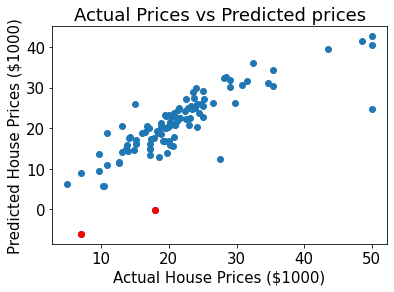

In [5]:
# We can plot the predicted prices to see that two examples have negative prices

plt.rcParams.update({'font.size': 15})
plt.scatter(y_test, y_pred)
neg_inds = np.where(y_pred <= 0)[0]
plt.scatter(y_test.values[neg_inds], y_pred[neg_inds], c='red')
plt.xlabel('Actual House Prices ($1000)')
plt.ylabel('Predicted House Prices ($1000)')
plt.title('Actual Prices vs Predicted prices')
plt.show()

In [6]:
for name, coef in zip(X_test.columns, reg_all.coef_):
    print('{}:\t {}'.format(name, coef))

CRIM:	 -0.11305592398537918
ZN:	 0.030110464145645492
INDUS:	 0.04038072041333996
CHAS:	 2.784438203508001
NOX:	 -17.202633391781642
RM:	 4.438835199513027
AGE:	 -0.006296362210981512
DIS:	 -1.4478653685307923
RAD:	 0.2624297355850869
TAX:	 -0.010646786275308401
PTRATIO:	 -0.9154562404680727
B:	 0.012351334729969188
LSTAT:	 -0.5085714244487959


In [7]:
X_test[X_test['LSTAT'] > 34]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
414,45.7461,0.0,18.1,0.0,0.693,4.519,100.0,1.6582,24.0,666.0,20.2,88.27,36.98
412,18.8110,0.0,18.1,0.0,0.597,4.628,100.0,1.5539,24.0,666.0,20.2,28.79,34.37
